In [1]:
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import requests


tickers_list = ['NVDA']

In [2]:
# 用 BeautifulSoup 浏览本周新闻头条

news = pd.DataFrame()

for ticker in tickers_list:
   url = f'https://finviz.com/quote.ashx?t={ticker}&p=d'
   ret = requests.get(
       url,
       headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36'},
   )

   html = BeautifulSoup(ret.content, "html.parser")

   try:
     df = pd.read_html(
         str(html),
         attrs={'class': 'fullview-news-outer'}
     )[0]
   except:
     print(f"{ticker} No news found")
     continue

   df.columns = ['Date', 'Headline']

df.tail()

C:\Users\haozh\AppData\Local\Temp\ipykernel_5676\1168922494.py:15: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(


,Date,Headline
98,05:30AM,Why Nvidia Needs to Appeal to a Bigger Crowd (...
99,05:30AM,Better Artificial Intelligence Stock: Wolfspee...
100,05:00AM,Nvidia CEO says the 'ChatGPT moment' for robot...
101,04:51AM,"1 ""Magnificent Seven"" Stock to Buy Hand Over F..."
102,04:25AM,Does the Valuation of SoundHound AI Stock Matt...


In [4]:
# Process date and time columns to make sure this is filled in every headline each row
dateNTime = df.Date.apply(lambda x: ','+x if len(x)<8 else x).str.split(r' |,', expand = True).replace("", None).ffill()

df = pd.merge(df, dateNTime, right_index=True, left_index=True).drop('Date', axis=1).rename(columns={0:'Date', 1:'Time'})

df = df[df["Headline"].str.contains("Loading.") == False].loc[:, ['Date', 'Time', 'Headline']]

df["Ticker"] = ticker
news = pd.concat([news, df], ignore_index = True)

news.head()

# NVDA 本周新闻头条

,Date,Time,Headline,Ticker
0,Today,06:41PM,Nvidias CES 2025 keynote: How to watch (TechCr...,NVDA
1,Today,06:26PM,Analysts focus on Nvidia ahead of key tech eve...,NVDA
2,Today,06:15PM,"AI infrastructure, compute: Ben Bajarin's 2025...",NVDA
3,Today,05:10PM,How to watch CES 2025s press conferences (Tech...,NVDA
4,Today,04:57PM,"As Hope of Santa Claus Rally Fades, What's Nex...",NVDA


In [5]:
# 使用 vader_lexicon 对 ['Headline'] 应用 SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
vader = SentimentIntensityAnalyzer()

scored_news = news.join(
  pd.DataFrame(news['Headline'].apply(vader.polarity_scores).tolist())
)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\haozh\AppData\Roaming\nltk_data...


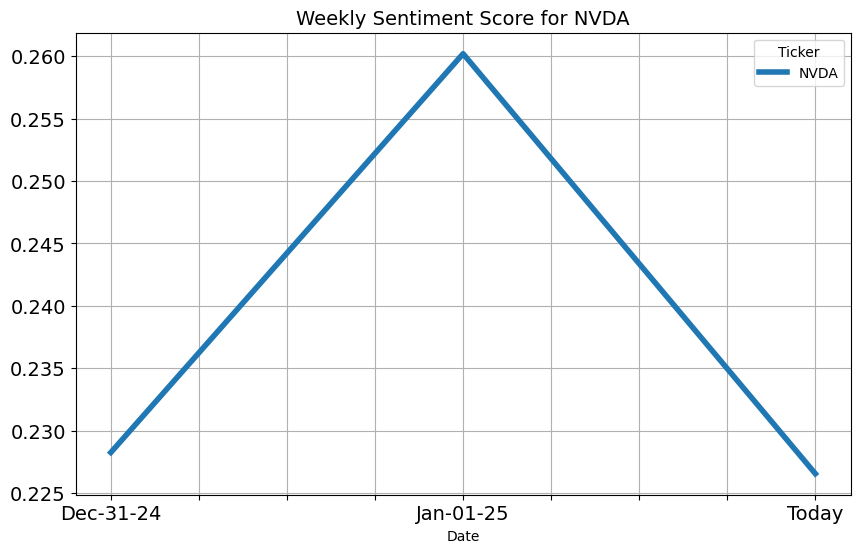

In [6]:
# 绘制 NVDA 的每周情绪得分图

news_score = scored_news.loc[:, ['Ticker', 'Date', 'compound']].pivot_table(values='compound', index='Date', columns='Ticker', aggfunc='mean').ewm(15).mean()
news_score.dropna().plot(figsize=(10, 6),linewidth=4,kind='line',legend=True, fontsize=14)
plt.title("Weekly Sentiment Score for NVDA",fontsize=14)
plt.grid()

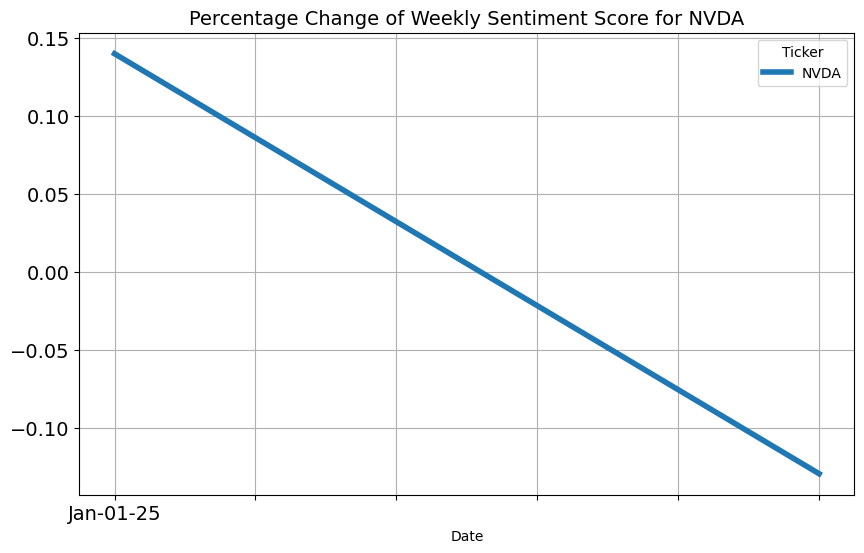

In [7]:
# 接下来我们绘制 NVDA 周情绪得分百分比变化图

news_score.pct_change().dropna().plot(figsize=(10, 6),linewidth=4,kind='line',legend=True, fontsize=14)
plt.title("Percentage Change of Weekly Sentiment Score for NVDA",fontsize=14)
plt.grid()

In [3]:
# 周矢量情绪评分
# 采集分析 AMZN 的股票新闻并计算每周向量情绪得分 {即：负面、中性、正面、复合

import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import pandas as pd
from urllib.request import urlopen, Request
from nltk.sentiment.vader import SentimentIntensityAnalyzer

web_url = 'https://finviz.com/quote.ashx?t='

news_tables = {}
tickers = ['AMZN', 'GOOG', 'TSLA']

for tick in tickers:
    url = web_url + tick
    req = Request(url=url,headers={"User-Agent": "Chrome"}) 
    response = urlopen(req)    
    html = BeautifulSoup(response,"html.parser")
    news_table = html.find(id='news-table')
    news_tables[tick] = news_table

amazon = news_tables['AMZN']
amazon_tr = amazon.findAll('tr')


In [4]:
filtered_rows = [row for row in amazon_tr if row.a is not None and row.td is not None]

for x, table_row in enumerate(filtered_rows):
    # Extract and print <a> tag text
    a_text = table_row.a.text
    print(a_text)

    # Extract and print <td> tag text
    td_text = table_row.td.text
    print(td_text)

    if x == 10:
        break
    

Here's Why Amazon (AMZN) Gained But Lagged the Market Today

            Today 05:45PM
        
Rigetti, IonQ stocks plunge after Nvidia CEO says 'useful' quantum computing is decades away

            04:07PM
        
Panama Canal CEO Says Meeting Trumps Demands Will Lead to Chaos

            02:48PM
        
Amazon AWS To Invest $11 Billion In Georgia To Boost AI And Cloud Infrastructure: 'Expect To Create More Than 550 Well-Paying Jobs'

            02:00PM
        
Intel Partners with Amazon Cloud to Drive Next-Gen Smart Vehicle Tech, Wins Stellantis, Karma Auto As Clients

            01:28PM
        
Cantor Fitzgerald Raises Amazon.com, Inc. (AMZN)s Price Target to $270, Highlighting Strong AI Growth and Future Potential

            01:16PM
        
"Motley Fool Money" 2025 Stock Market Preview

            12:55PM
        
Amazon (AMZN) Upgraded to Strong Buy: Here's Why

            12:00PM
        
Amazon's $11 Billion Investment Targets Cloud Growth in Georgia

            

In [5]:
#  创建新闻列表

news_list = []

for file_name, news_table in news_tables.items():
    filtered_rows = [row for row in news_table.findAll('tr') if row.a is not None]

    for row in filtered_rows:
        # Extract the text from the <a> tag
        text = row.a.get_text()

        # Extract and split the <td> content
        date_scrape = row.td.text.split()

        # Handle cases for "Today", "Yesterday", and time-only entries
        if len(date_scrape) == 1:
            if date_scrape[0] in ["Today", "Yesterday"]:
                date = date_scrape[0]
                time = None  # No specific time in this case
            else:
                date = None
                time = date_scrape[0]  # Time-only entry
        else:
            date = date_scrape[0]  # Extract date
            time = date_scrape[1]  # Extract time

        # Extract the ticker symbol
        tick = file_name.split('_')[0]

        # Append the processed information to the news list
        news_list.append([tick, date, time, text])

#print(news_list)


for entry in news_list:
    print(f"Ticker: {entry[0]}, Date: {entry[1]}, Time: {entry[2]}, Title: {entry[3]}")
    

Ticker: AMZN, Date: Today, Time: 05:45PM, Title: Here's Why Amazon (AMZN) Gained But Lagged the Market Today
Ticker: AMZN, Date: None, Time: 04:07PM, Title: Rigetti, IonQ stocks plunge after Nvidia CEO says 'useful' quantum computing is decades away
Ticker: AMZN, Date: None, Time: 02:48PM, Title: Panama Canal CEO Says Meeting Trumps Demands Will Lead to Chaos
Ticker: AMZN, Date: None, Time: 02:00PM, Title: Amazon AWS To Invest $11 Billion In Georgia To Boost AI And Cloud Infrastructure: 'Expect To Create More Than 550 Well-Paying Jobs'
Ticker: AMZN, Date: None, Time: 01:28PM, Title: Intel Partners with Amazon Cloud to Drive Next-Gen Smart Vehicle Tech, Wins Stellantis, Karma Auto As Clients
Ticker: AMZN, Date: None, Time: 01:16PM, Title: Cantor Fitzgerald Raises Amazon.com, Inc. (AMZN)s Price Target to $270, Highlighting Strong AI Growth and Future Potential
Ticker: AMZN, Date: None, Time: 12:55PM, Title: "Motley Fool Money" 2025 Stock Market Preview
Ticker: AMZN, Date: None, Time: 12:

In [6]:
from prettytable import PrettyTable

# Create a PrettyTable instance
table = PrettyTable()
table.field_names = ["Ticker", "Date", "Time", "Title"]

# Add rows to the table
for entry in news_list:
    table.add_row(entry)

# Set alignment: Left align the "Title" column
table.align["Title"] = "l"

# Print the table
print(table)


+--------+-----------+---------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Ticker |    Date   |   Time  | Title                                                                                                                                                              |
+--------+-----------+---------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|  AMZN  |   Today   | 05:45PM | Here's Why Amazon (AMZN) Gained But Lagged the Market Today                                                                                                        |
|  AMZN  |    None   | 04:07PM | Rigetti, IonQ stocks plunge after Nvidia CEO says 'useful' quantum computing is decades away                                                                       |
|  AMZN  |

In [7]:
# 将上述列表转换为数据帧

vader = SentimentIntensityAnalyzer()

columns = ['ticker', 'date', 'time', 'headline']

news_df = pd.DataFrame(news_list, columns=columns)

scores = news_df['headline'].apply(vader.polarity_scores).tolist()

scores_df = pd.DataFrame(scores)

news_df = news_df.join(scores_df, rsuffix='_right')

news_df=news_df.replace('Today', 'Dec-18-24')

news_df.head()


,ticker,date,time,headline,neg,neu,pos,compound
0,AMZN,Dec-18-24,05:45PM,Here's Why Amazon (AMZN) Gained But Lagged the...,0.216,0.541,0.243,-0.1655
1,AMZN,None,04:07PM,"Rigetti, IonQ stocks plunge after Nvidia CEO s...",0.000,1.000,0.000,0.0000
2,AMZN,None,02:48PM,Panama Canal CEO Says Meeting Trumps Demands W...,0.270,0.730,0.000,-0.5719
3,AMZN,None,02:00PM,Amazon AWS To Invest $11 Billion In Georgia To...,0.000,0.745,0.255,0.6705
4,AMZN,None,01:28PM,Intel Partners with Amazon Cloud to Drive Next...,0.000,0.633,0.367,0.7964


In [8]:
# 创建并绘制平均矢量情感分数

import datetime
mydf=pd.DataFrame(news_df, columns=['neg', 'neu','pos','compound','date'])
mydfneg=mydf.groupby(mydf['date']).mean()

mydfneg.head()

,neg,neu,pos,compound
date,,,,
Dec-18-24,0.0720,0.748333,0.179667,0.157133
Jan-02-25,0.0000,1.000000,0.000000,0.000000
Jan-03-25,0.3605,0.550500,0.089000,-0.459000
Jan-04-25,0.0960,0.759000,0.145000,0.113150
Jan-05-25,0.0000,1.000000,0.000000,0.000000


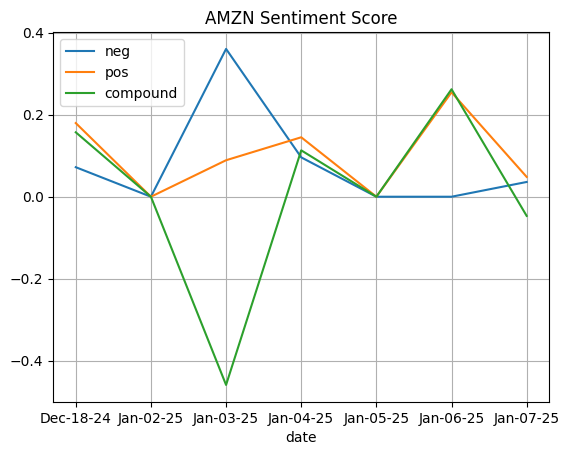

In [9]:
mydfneg['neg'].plot(label='neg')
mydfneg['pos'].plot(label='pos')
mydfneg['compound'].plot(label='compound')
plt.legend()
plt.title('AMZN Sentiment Score')
plt.grid()

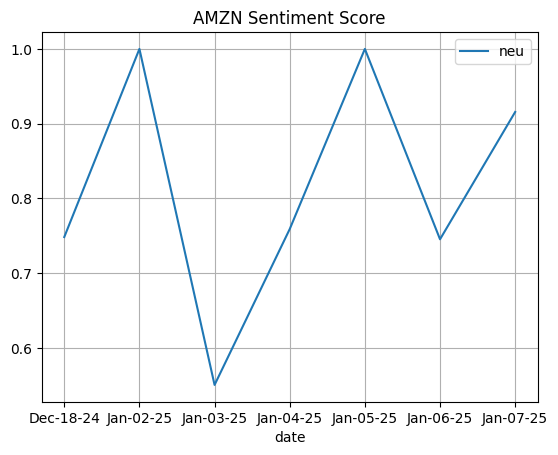

In [10]:
# 为便于比较，接着绘制中性情绪平均得分图

mydfneg['neu'].plot(label='neu')
plt.legend()
plt.title('AMZN Sentiment Score')
plt.grid()



In [11]:
# 让我们接着比较一下对 AMZN 的负面和正面评价

news_df.loc[:,'date'] = pd.to_datetime(news_df.date.astype(str)+' '+news_df.time.astype(str))

news_df.head()


C:\Users\haozh\AppData\Local\Temp\ipykernel_5676\1731635240.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  news_df.loc[:,'date'] = pd.to_datetime(news_df.date.astype(str)+' '+news_df.time.astype(str))


DateParseError: Unknown datetime string format, unable to parse: None 04:07PM, at position 1